# Import Dependencies

In [4]:
import cv2
import os
import logging
import time
import numpy as np
import mediapipe as mp
import json
from tqdm import tqdm # for progress bars in Jupyter Notebook
from matplotlib import pyplot as plt

## Detecting Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [3]:
def setup_holistic_detection():
    # Initialize Camera Input
    cap = cv2.VideoCapture(0)

    # Set Up MediaPipe Holistic Model
    holistic = mp_holistic.Holistic(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    )

    return cap, holistic

In [4]:
def process_mp_frames(frame, holistic):
    # Opencv records in BGR while mediapipe supports RGB
    # We need to recolor frame to RGB to support MediaPipe processing
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False                  # Make Image non-writeable for performance
    results = holistic.process(image)              # process image and return object contain landmarks
    image.flags.writeable = True                   # Back to writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # Color back to BGR for OpenCV 

    return image, results

In [5]:
def draw_landmarks(image, results):
    # Draw face landmarks
    mp_drawing.draw_landmarks(image, 
                              results.face_landmarks, 
                              mp_holistic.FACEMESH_TESSELATION, # FACEMESH_CONTOURS could also be valid here
                              landmark_drawing_spec=mp_drawing.DrawingSpec(color=(170,86,0), thickness=1, circle_radius=2),
                              connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())
    # Draw pose connections
    mp_drawing.draw_landmarks(image, 
                              results.pose_landmarks, 
                              mp_holistic.POSE_CONNECTIONS,
                              landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, 
                              results.left_hand_landmarks, 
                              mp_holistic.HAND_CONNECTIONS,
                              landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style(), 
                              connection_drawing_spec=mp_drawing_styles.get_default_hand_connections_style())
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, 
                              results.right_hand_landmarks, 
                              mp_holistic.HAND_CONNECTIONS,
                              landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style(), 
                              connection_drawing_spec=mp_drawing_styles.get_default_hand_connections_style())
    

In [6]:
def extract_keypoints_comprehensive(results):
    # Pose Landmarks have 33 Keypoints
    # if results.pose_landmarks:
    #     pose_landmarks = []
    #     for res in results.pose_landmakrs.landmark:
    #         pose_landmarks.extend([res.x, res.y, res.z, res.visibility])
    #     pose = np.array(pose_landmarks)
    # else:
    #     pose = np.zeros(33*4)
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    keypoints_vector = np.concatenate([pose, face, lh, rh])
    # print(keypoints_vector)
    return keypoints_vector

In [7]:
def run_holistic_detection():
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow loggin
    logging.getLogger('mediapipe').setLevel(logging.ERROR)  # Only show errors from mediapipe
    cap, holistic = setup_holistic_detection()

    while cap.isOpened():
        # Read frame
        ret, frame = cap.read()
        if not ret:
            print('camera stopped: no frames grabbed')
            break

        # Process Frame/Make dectections
        image, results = process_mp_frames(frame, holistic)
        # print(results)

        # Draw Landmarks
        draw_landmarks(image, results)

        # Extract Keypoints
        keypoints_vector = extract_keypoints_comprehensive(results)

        # Show to screen
        cv2.imshow('ASL Detection', image)

        # Exit on 'q' press
        if cv2.waitKey(10) & 0xFF == ord('q'):
            draw_landmarks(frame, results)
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            break

    cap.release()
    cv2.destroyAllWindows()

I0000 00:00:1743529069.183453 3020263 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1743529069.273954 3093787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743529069.289612 3093787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743529069.292698 3093794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743529069.292704 3093795 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743529069.292803 3093790 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

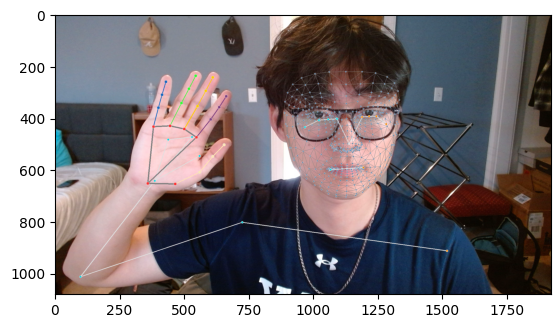

In [27]:
run_holistic_detection()

## Dataset Collection Pipeline for Custom Camera Recordings

In [8]:
# Create Directories to store data
def create_directories(actions):
    DATA_PATH = os.path.join('MP_Data')

    # Detecting Actions
    for action in actions:
        # 30 is often considered minimum threshold to detect meaningful patterns
        # n >= 30 commonly used as rule of thumb
        for sequence in range(30): # 30 videos per action 
            try:
                os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
            except:
                pass

def collect_asl_data():
    # Define Actions - starting with a small set for testing
    actions = np.array(['hello', 'thanks', ' I love you', 'yes', 'no', 'please', 'sorry'])

    # create directories for data collection - 30 directories per action
    create_directories(actions)

    # Define data path
    DATA_PATH = os.path.join('MP_Data')

    # set up holistic model
    cap, holistic = setup_holistic_detection()

    # Loop through different actions
    for action in actions:
        # loop through sequences
        for sequence in range(30):
            # loop through video length of 30 frames
            for frame_num in range(30):
                # Read Feed
                ret, frame = cap.read()
                if not ret:
                    print('Failed to grab frame')
                    break

                # Process the frame for landmark detection
                image, results = process_mp_frames(frame, holistic)

                # Draw Landmarks on the image
                draw_landmarks(image, results)

                # Apply status text to the frame
                if frame_num == 0:
                    # Visual Countdown before starting each sequence
                    cv2.putText(image, 'STARTING COLLECTION', (120, 200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, f'Collecting for {action} - Sequence {sequence}', (15, 15), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                    cv2.imshow('ASL Data Collection', image)
                    cv2.waitKey(2000)  # Wait 2 seconds before starting
                else:
                    # Display collection status
                    cv2.putText(image, f'Collecting for {action} - Sequence {sequence}', (15, 15), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                    cv2.putText(image, f'Frame {frame_num}', (15, 30), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

                # show to screen
                cv2.imshow('ASK Data Collection', image)

                # Export keypoints
                keypoints_vector = extract_keypoints_comprehensive(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints_vector)
                
                # Break gracefully on 'q' press
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    cap.release()
                    cv2.destroyAllWindows()
                    return
            
            # Short break between sequences
            if sequence < 29:  # Don't show after the last sequence
                # Display break message
                ret, frame = cap.read()
                if ret:
                    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    cv2.putText(image, 'SEQUENCE COMPLETE', (120, 200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Preparing for next sequence...', (120, 230), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
                    cv2.imshow('ASL Data Collection', image)
                cv2.waitKey(2000)  # 2 second break
    
    # Release resources
    cap.release()
    cv2.destroyAllWindows()
    print("Data collection complete!")

In [9]:
collect_asl_data()

2025-04-07 17:29:52.425 Python[6370:10803382] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
I0000 00:00:1744061393.844555 10803382 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1744061393.907532 10803838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744061393.922779 10803841 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744061393.925152 10803841 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744061393.925284 10803843 infer

Data collection complete!


## LSTM Model for Custom ASL Data

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [20]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [21]:
def load_custom_data(data_path, actions, sequence_length=30):
    """
    Load custom collected ASL data
    
    Args:
        data_path: Path to data (MP_Data directory)
        actions: List of actions/signs
        sequence_length: Length of each sequence
        
    Returns:
        X, y: Features and labels
    """
    sequences, labels = [], []
    
    # Loop through each action
    for action_idx, action in enumerate(actions):
        # Loop through sequences
        for sequence in range(30):
            window = []
            
            # Loop through frames in sequence
            for frame_num in range(sequence_length):
                # Load frame data if it exists
                frame_path = os.path.join(data_path, action, str(sequence), str(frame_num) + '.npy')
                
                if os.path.exists(frame_path):
                    # Load the landmarks
                    frame = np.load(frame_path)
                    window.append(frame)
                else:
                    print(frame_path)
                    print(f"Warning: Missing frame {frame_num} in {action} sequence {sequence}")
            
            # Only add if we have a complete sequence
            if len(window) == sequence_length:
                sequences.append(window)
                labels.append(action_idx)
    
    # Convert to numpy arrays
    X = np.array(sequences)
    y = to_categorical(labels).astype(int)
    
    return X, y

In [22]:
def create_model(input_shape, num_classes, learning_rate=0.001):
    """
    Create an LSTM model with regularization for ASL recognition
    
    Args:
        input_shape: Shape of input sequences (sequence_length, num_features)
        num_classes: Number of sign classes
        learning_rate: Learning rate for Adam optimizer
        
    Returns:
        Compiled model
    """
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(64, return_sequences=True, activation='relu', 
                  input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Second LSTM layer
    model.add(LSTM(128, return_sequences=True, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Third LSTM layer
    model.add(LSTM(64, return_sequences=False, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # Use Adam optimizer with specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile model
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    
    return model

In [23]:
def custom_dataset_test():
    # Define actions - match these to your collected data
    actions = np.array(['hello', 'thanks', 'iloveyou', 'yes', 'no', 'please', 'sorry'])
    
    # Path to your custom collected data
    data_path = 'MP_Data_01'
    
    # Create logs and models directories
    os.makedirs('Logs', exist_ok=True)
    os.makedirs('Models', exist_ok=True)
    
    # Load data
    print("Loading data...")
    X, y = load_custom_data(data_path, actions)
    
    # Print data info
    print(f"Data shape: {X.shape}")
    print(f"Label shape: {y.shape}")
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
    
    # Create model
    input_shape = (X.shape[1], X.shape[2])  # (sequence_length, num_features)
    model = create_model(input_shape, len(actions), learning_rate=0.0001)
    
    # Print model summary
    model.summary()
    
    # Create callbacks
    tb_callback = TensorBoard(log_dir='Logs')
    checkpoint_callback = ModelCheckpoint(
        'Models/best_model.h5',
        monitor='val_categorical_accuracy',
        verbose=1,
        save_best_only=True
    )
    
    # Train model
    print("Training model...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=150,  # Train for more epochs
        batch_size=16,  # Smaller batch size
        callbacks=[tb_callback, checkpoint_callback]
    )
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    
    # Evaluate on test data
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {test_acc:.4f}")
    
    # Save model
    model.save('Models/model_1.keras')
    print("Model saved to 'Models/model_1.keras'")
    
    # Make predictions on test data
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Print some example predictions
    print("\nExample predictions:")
    for i in range(min(5, len(y_true_classes))):
        true_action = actions[y_true_classes[i]]
        pred_action = actions[y_pred_classes[i]]
        confidence = y_pred[i][y_pred_classes[i]]
        print(f"True: {true_action}, Predicted: {pred_action}, Confidence: {confidence:.4f}")

Loading data...
Data shape: (210, 30, 1662)
Label shape: (210, 7)
Training samples: 168, Test samples: 42


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 597,831 (2.28 MB)

 Trainable params: 597,319 (2.28 MB)

 Non-trainable params: 512 (2.00 KB)

Training model...
Epoch 1/150
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.1366 - loss: 2.7105
Epoch 1: val_categorical_accuracy improved from -inf to 0.07143, saving model to Models/best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - categorical_accuracy: 0.1396 - loss: 2.6972 - val_categorical_accuracy: 0.0714 - val_loss: 1.9457
Epoch 2/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.1937 - loss: 2.4842
Epoch 2: val_categorical_accuracy improved from 0.07143 to 0.16667, saving model to Models/best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_accuracy: 0.1924 - loss: 2.4823 - val_categorical_accuracy: 0.1667 - val_loss: 1.9404
Epoch 3/150
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.2157 - loss: 2.3418
Epoch 3: val_categorical_accuracy did not improve from 0.16667
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - categorical_accuracy: 0.2125 - loss: 2.3338 - val_categorical_accuracy: 0.1667 - val_loss: 1.9312
Epoch 4/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_accuracy: 0.1951 - loss: 2.2676
Epoch 4: val_categorical_accuracy did not improve from 0.16667
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_accuracy: 0.1987 - loss: 2.2631 - val_categorical_accuracy: 0.1190 - val_loss: 1.9408
Epoch 5/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_accuracy: 0.2477 - loss: 2.1570
Epoch 5: val_categorical_accuracy did not improve from 0.16667
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.2474 - loss: 2.1567 - val_categ

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - categorical_accuracy: 0.2745 - loss: 1.9320 - val_categorical_accuracy: 0.1905 - val_loss: 1.9550
Epoch 8/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.2598 - loss: 2.0097
Epoch 8: val_categorical_accuracy did not improve from 0.19048
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - categorical_accuracy: 0.2585 - loss: 2.0088 - val_categorical_accuracy: 0.0714 - val_loss: 1.9637
Epoch 9/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_accuracy: 0.3193 - loss: 1.9211
Epoch 9: val_categorical_accuracy did not improve from 0.19048
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.3190 - loss: 1.9194 - val_categorical_accuracy: 0.0714 - val_loss: 1.9663
Epoch 10/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.3470 - loss: 1.7768
Epoch 10: val_categorical_accuracy did not improve from 0.19048
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - categorical_accuracy: 0.3483 - loss: 1.7742 - val_cat

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - categorical_accuracy: 0.3840 - loss: 1.5795 - val_categorical_accuracy: 0.2143 - val_loss: 1.9326
Epoch 15/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_accuracy: 0.3776 - loss: 1.5160
Epoch 15: val_categorical_accuracy did not improve from 0.21429
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.3789 - loss: 1.5179 - val_categorical_accuracy: 0.1905 - val_loss: 1.9690
Epoch 16/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_accuracy: 0.5231 - loss: 1.3764
Epoch 16: val_categorical_accuracy improved from 0.21429 to 0.26190, saving model to Models/best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.5207 - loss: 1.3814 - val_categorical_accuracy: 0.2619 - val_loss: 1.9174
Epoch 17/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.4625 - loss: 1.3801
Epoch 17: val_categorical_accuracy did not improve from 0.26190
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - categorical_accuracy: 0.4631 - loss: 1.3815 - val_categorical_accuracy: 0.2143 - val_loss: 1.9187
Epoch 18/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.5413 - loss: 1.2951
Epoch 18: val_categorical_accuracy did not improve from 0.26190
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.5389 - loss: 1.2988 - val_categorical_accuracy: 0.2381 - val_loss: 1.9067
Epoch 19/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_accuracy: 0.5925 - loss: 1.2688
Epoch 19: val_categorical_accuracy did not improve from 0.26190
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.5917 - loss: 1.2701 - val

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - categorical_accuracy: 0.6475 - loss: 1.1090 - val_categorical_accuracy: 0.3810 - val_loss: 1.8101
Epoch 24/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_accuracy: 0.6158 - loss: 1.0608
Epoch 24: val_categorical_accuracy did not improve from 0.38095
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.6151 - loss: 1.0654 - val_categorical_accuracy: 0.2143 - val_loss: 1.8778
Epoch 25/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.6388 - loss: 1.0527
Epoch 25: val_categorical_accuracy did not improve from 0.38095
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.6386 - loss: 1.0548 - val_categorical_accuracy: 0.2619 - val_loss: 1.8138
Epoch 26/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.6803 - loss: 0.9670
Epoch 26: val_categorical_accuracy improved from 0.38095 to 0.45238, saving model to Models/best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - categorical_accuracy: 0.6782 - loss: 0.9713 - val_categorical_accuracy: 0.4524 - val_loss: 1.7668
Epoch 27/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.6602 - loss: 1.0707
Epoch 27: val_categorical_accuracy improved from 0.45238 to 0.47619, saving model to Models/best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - categorical_accuracy: 0.6588 - loss: 1.0698 - val_categorical_accuracy: 0.4762 - val_loss: 1.7530
Epoch 28/150
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.6584 - loss: 1.0193
Epoch 28: val_categorical_accuracy did not improve from 0.47619
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - categorical_accuracy: 0.6538 - loss: 1.0280 - val_categorical_accuracy: 0.2381 - val_loss: 1.9400
Epoch 29/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_accuracy: 0.7197 - loss: 0.9718
Epoch 29: val_categorical_accuracy did not improve from 0.47619
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - categorical_accuracy: 0.7152 - loss: 0.9753 - val_categorical_accuracy: 0.4524 - val_loss: 1.7490
Epoch 30/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_accuracy: 0.7451 - loss: 0.8756
Epoch 30: val_categorical_accuracy did not improve from 0.47619
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.7436 - loss: 0.8799 - val

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - categorical_accuracy: 0.7813 - loss: 0.8557 - val_categorical_accuracy: 0.5000 - val_loss: 1.6220
Epoch 35/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.7512 - loss: 0.8648
Epoch 35: val_categorical_accuracy did not improve from 0.50000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.7511 - loss: 0.8631 - val_categorical_accuracy: 0.2857 - val_loss: 1.8393
Epoch 36/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.6970 - loss: 0.8328
Epoch 36: val_categorical_accuracy did not improve from 0.50000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.6985 - loss: 0.8330 - val_categorical_accuracy: 0.4048 - val_loss: 1.5726
Epoch 37/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.7606 - loss: 0.8312
Epoch 37: val_categorical_accuracy improved from 0.50000 to 0.71429, saving model to Models/best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - categorical_accuracy: 0.7592 - loss: 0.8325 - val_categorical_accuracy: 0.7143 - val_loss: 1.3151
Epoch 38/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.7683 - loss: 0.7530
Epoch 38: val_categorical_accuracy did not improve from 0.71429
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.7668 - loss: 0.7556 - val_categorical_accuracy: 0.6667 - val_loss: 1.4341
Epoch 39/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.7452 - loss: 0.7600
Epoch 39: val_categorical_accuracy did not improve from 0.71429
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.7441 - loss: 0.7633 - val_categorical_accuracy: 0.5000 - val_loss: 1.5525
Epoch 40/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.7896 - loss: 0.7592
Epoch 40: val_categorical_accuracy did not improve from 0.71429
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.7882 - loss: 0.7630 - val

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - categorical_accuracy: 0.8406 - loss: 0.6909 - val_categorical_accuracy: 0.7857 - val_loss: 1.1031
Epoch 46/150
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.8391 - loss: 0.6287
Epoch 46: val_categorical_accuracy did not improve from 0.78571
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - categorical_accuracy: 0.8381 - loss: 0.6360 - val_categorical_accuracy: 0.3810 - val_loss: 1.2146
Epoch 47/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.8539 - loss: 0.5339
Epoch 47: val_categorical_accuracy did not improve from 0.78571
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - categorical_accuracy: 0.8537 - loss: 0.5408 - val_categorical_accuracy: 0.3571 - val_loss: 2.4550
Epoch 48/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_accuracy: 0.8427 - loss: 0.6049
Epoch 48: val_categorical_accuracy did not improve from 0.78571
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - categorical_accuracy: 0.8419 - loss: 0.6074 - val

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - categorical_accuracy: 0.8484 - loss: 0.5815 - val_categorical_accuracy: 0.9048 - val_loss: 0.7429
Epoch 56/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_accuracy: 0.8643 - loss: 0.5537
Epoch 56: val_categorical_accuracy did not improve from 0.90476
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - categorical_accuracy: 0.8647 - loss: 0.5549 - val_categorical_accuracy: 0.1190 - val_loss: 3.4785
Epoch 57/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_accuracy: 0.9266 - loss: 0.4436
Epoch 57: val_categorical_accuracy did not improve from 0.90476
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - categorical_accuracy: 0.9247 - loss: 0.4472 - val_categorical_accuracy: 0.5714 - val_loss: 1.1920
Epoch 58/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.8864 - loss: 0.4549
Epoch 58: val_categorical_accuracy did not improve from 0.90476
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - categorical_accuracy: 0.8864 - loss: 0.4566 - val

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - categorical_accuracy: 0.9146 - loss: 0.3459 - val_categorical_accuracy: 0.9286 - val_loss: 0.4036
Epoch 72/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.9550 - loss: 0.3287
Epoch 72: val_categorical_accuracy did not improve from 0.92857
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - categorical_accuracy: 0.9533 - loss: 0.3300 - val_categorical_accuracy: 0.7857 - val_loss: 0.6148
Epoch 73/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_accuracy: 0.9803 - loss: 0.3109
Epoch 73: val_categorical_accuracy did not improve from 0.92857
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - categorical_accuracy: 0.9790 - loss: 0.3111 - val_categorical_accuracy: 0.5476 - val_loss: 1.7497
Epoch 74/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_accuracy: 0.9569 - loss: 0.2925
Epoch 74: val_categorical_accuracy did not improve from 0.92857
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - categorical_accuracy: 0.9561 - loss: 0.2947 - val

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - categorical_accuracy: 0.9941 - loss: 0.1127 - val_categorical_accuracy: 0.9524 - val_loss: 0.2879
Epoch 116/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.9904 - loss: 0.1228
Epoch 116: val_categorical_accuracy did not improve from 0.95238
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - categorical_accuracy: 0.9897 - loss: 0.1237 - val_categorical_accuracy: 0.9048 - val_loss: 0.2158
Epoch 117/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.9916 - loss: 0.1126
Epoch 117: val_categorical_accuracy did not improve from 0.95238
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - categorical_accuracy: 0.9908 - loss: 0.1127 - val_categorical_accuracy: 0.8571 - val_loss: 0.3851
Epoch 118/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - categorical_accuracy: 0.9891 - loss: 0.1416
Epoch 118: val_categorical_accuracy did not improve from 0.95238
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - categorical_accuracy: 0.9881 - loss: 0.1426

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - categorical_accuracy: 0.9930 - loss: 0.0802 - val_categorical_accuracy: 0.9762 - val_loss: 0.1718
Epoch 138/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_accuracy: 0.9775 - loss: 0.0855
Epoch 138: val_categorical_accuracy did not improve from 0.97619
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - categorical_accuracy: 0.9784 - loss: 0.0854 - val_categorical_accuracy: 0.7857 - val_loss: 0.6656
Epoch 139/150
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.9987 - loss: 0.0632
Epoch 139: val_categorical_accuracy did not improve from 0.97619
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - categorical_accuracy: 0.9970 - loss: 0.0669 - val_categorical_accuracy: 0.6190 - val_loss: 1.7285
Epoch 140/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.9989 - loss: 0.0913
Epoch 140: val_categorical_accuracy did not improve from 0.97619
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - categorical_accuracy: 0.9985 - loss: 0.0911

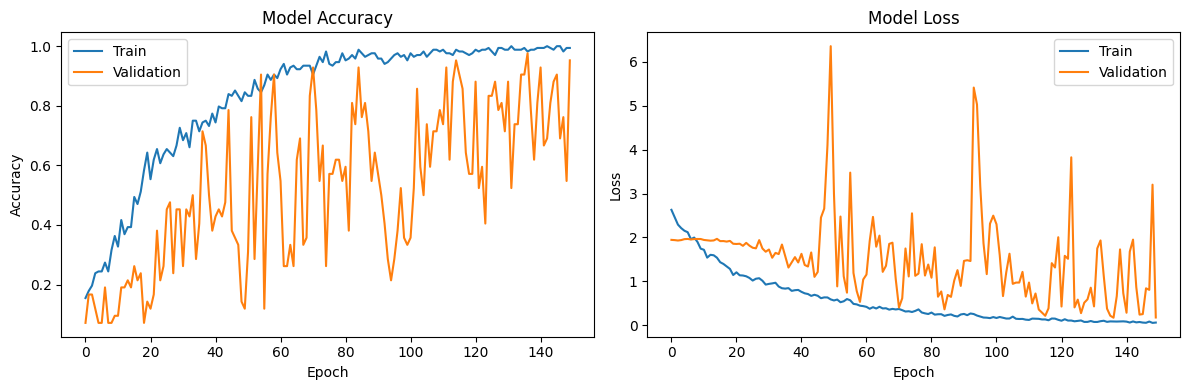

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9474 - loss: 0.1900
Test accuracy: 0.9524
Model saved to 'Models/model_1.keras'
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step

Example predictions:
True: thanks, Predicted: iloveyou, Confidence: 0.5002
True: please, Predicted: please, Confidence: 0.9892
True: iloveyou, Predicted: iloveyou, Confidence: 0.9999
True: sorry, Predicted: sorry, Confidence: 0.9968
True: iloveyou, Predicted: iloveyou, Confidence: 0.9907


In [24]:
custom_dataset_test()

In [25]:
from collections import deque

def prob_viz(res, actions, input_frame, colors):
    """
    Visualize probabilities for each action
    """
    output_frame = input_frame.copy()
    
    # Draw rectangles and text for each action
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60 + num * 40), (int(prob * 100), 90 + num * 40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    return output_frame

def real_time_asl_detection():
    # Define actions - must match the ones used for training
    actions = np.array(['hello', 'thanks', 'iloveyou', 'yes', 'no', 'please', 'sorry'])
    
    # Define colors for visualization
    colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245), (255, 0, 0), (0, 255, 0), (0, 0, 255), (200, 200, 200)]
    
    # Load the model
    model_path = 'Models/final_model.h5'
    if not os.path.exists(model_path):
        print(f"Error: Model not found at {model_path}")
        return
    
    model = tf.keras.models.load_model(model_path)
    print(f"Model loaded from {model_path}")
    
    # Initialize sequence buffer
    sequence = deque(maxlen=30)
    
    # Initialize prediction variables
    sentence = []
    threshold = 0.8  # Confidence threshold
    last_prediction_time = 0
    cooldown = 2.0  # Seconds between predictions
    
    # Initialize webcam
    cap = cv2.VideoCapture(0)
    
    # Initialize MediaPipe Holistic
    with mp_holistic.Holistic(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as holistic:
        while cap.isOpened():
            # Read frame
            ret, frame = cap.read()
            if not ret:
                print("Failed to grab frame")
                break
                
            # Make frame smaller for faster processing
            frame = cv2.resize(frame, (640, 480))
            
            # Process frame
            image, results = process_mp_frames(frame, holistic)
            
            # Draw landmarks
            draw_landmarks(image, results)
            
            # Extract keypoints
            keypoints = extract_keypoints_comprehensive(results)
            
            # Add to sequence
            sequence.append(keypoints)
            
            # Make prediction when buffer is full
            if len(sequence) == 30:
                # Prepare for model
                input_data = np.expand_dims(np.array(sequence), axis=0)
                
                # Get prediction
                res = model.predict(input_data, verbose=0)[0]
                
                # Get class with highest probability
                predicted_class_idx = np.argmax(res)
                predicted_class = actions[predicted_class_idx]
                confidence = res[predicted_class_idx]
                
                # Only add prediction if confidence is high enough and cooldown has passed
                current_time = time.time()
                if confidence > threshold and (current_time - last_prediction_time) > cooldown:
                    # Add prediction to sentence if it's different from the last one
                    if len(sentence) == 0 or predicted_class != sentence[-1]:
                        sentence.append(predicted_class)
                        # Limit sentence length
                        if len(sentence) > 5:
                            sentence = sentence[-5:]
                    
                    last_prediction_time = current_time
                
                # Visualize probabilities
                image = prob_viz(res, actions, image, colors)
            
            # Show prediction on frame
            cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
            
            # Show current detected sign
            if len(sentence) > 0:
                cv2.putText(image, f"Detected: {sentence[-1]}", (3, 30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            # Show full sentence
            if len(sentence) > 1:
                # Position at bottom of frame
                sentence_text = ' '.join(sentence)
                text_size = cv2.getTextSize(sentence_text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
                
                # Create transparent overlay for text
                overlay = image.copy()
                cv2.rectangle(overlay, (0, image.shape[0] - 50), (image.shape[1], image.shape[0]), (0, 0, 0), -1)
                alpha = 0.7
                image = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)
                
                # Draw text
                cv2.putText(image, sentence_text, (10, image.shape[0] - 20), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2, cv2.LINE_AA)
            
            # Show frame
            cv2.imshow('ASL Detection', image)
            
            # Break on 'q' key
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
    
    # Release resources
    cap.release()
    cv2.destroyAllWindows()


In [26]:
real_time_asl_detection()

I0000 00:00:1744063955.566540 10803382 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1744063955.630744 10917197 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744063955.647916 10917197 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744063955.651201 10917199 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744063955.651247 10917200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744063955.652400 10917204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disablin

Model loaded from Models/final_model.h5


## Dataset Collection and Processing Pipeline for Pre-built Dataset

In [ ]:
WLASL_PATH = "WLASL_DATA"
VIDEOS_PATH = os.path.join(WLASL_PATH, "videos")
JSON_PATH = os.path.join(WLASL_PATH, "WLASL_v0.3.json")
OUTPUT_PATH = "WLASL_Processed"

# Create Output directory
os.makedirs(OUTPUT_PATH, exist_ok=True)

**Verify Dataset Structure**

In [ ]:
print("WLASL folder contents:")
print(os.listdir(WLASL_PATH))

# If there's a JSON file, check its structure
json_path = os.path.join(WLASL_PATH, "WLASL_v0.3.json")
if os.path.exists(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    print(f"\nJSON file contains data for {len(data)} signs")
    print(f"Example of first sign: {data[0]['gloss']}")

**Process Videos**

In [ ]:
def process_video(video_path, output_dir, max_frames=30):
    """Process a single video file and extract landmarks"""
    # Create Output Directory
    os.makedirs(output_dir, exist_ok=True)

    # open video
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate frame sampling rate
    if frame_count <= max_frames:
        # Use all frames is video is short
        frame_indices = list(range(frame_count))
    else:
        # Sample frames evenly if video is long
        frame_indices = np.linspace(0, frame_count-1, max_frames, dtype=int)

    # Initialize MediaPipe
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        # Process Frames
        for frame_idx, i in enumerate(frame_indices):
            # Set frame position
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            success, frame = cap.read()

            if not success:
                print(f"Could not read frame {i} from {video_path}")
                continue
                
            # Process image
            image, results = process_mp_frames(frame, holistic)
            
            # Extract and savve keypoints
            keypoints_vector = extract_keypoints_comprehensive(results)
            npy_path = os.path.join(output_dir, str(frame_idx))
            np.save(npy_path, keypoints_vector)

    cap.release()
    return len(frame_indices)

In [ ]:
def process_wlasl_dataset(max_signs=None, max_videos_per_sign=30):
    """Process the WLASL dataset"""
    # Load WLASL metadata
    with open(JSON_PATH, 'r') as f:
        wlasl_data = json.load(f)

    # Limit number of signs if specified
    if max_signs:
        wlasl_data = wlasl_data[:max_signs]

    # list to store sign info
    processed_signs = []

    # Create sign to ID mapping
    sign_map = {sign_data['gloss']: idx for idx, sign_data in enumerate(wlasl_data)}

    # Save sign map for later use
    with open(os.path.join(OUTPUT_PATH, 'sign_map.json'), 'w') as f:
        json.dump(sign_map, f, indent=2)

    # Process each sign
    for sign_idx, sign_data in enumerate(tqdm(wlasl_data, desc="Processing signs")):
        sign_name = sign_data['gloss']
        sign_id = sign_idx  # Use index as class ID
        
        # Create directory for this sign
        sign_dir = os.path.join(OUTPUT_PATH, sign_name)
        os.makedirs(sign_dir, exist_ok=True)

        # Process videos for this sign
        videos_processed = 0
        
        for i, instance in enumerate(sign_data['instances']):
            if videos_processed >= max_videos_per_sign:
                break
                
            video_id = instance['video_id']
            video_path = os.path.join(VIDEOS_PATH, f"{video_id}.mp4")
            
            # Check if video exists
            if not os.path.exists(video_path):
                print(f"Video not found: {video_path}")
                continue
            
            # Process video
            output_dir = os.path.join(sign_dir, str(videos_processed))
            frames_processed = process_video(video_path, output_dir)
            
            if frames_processed > 0:
                videos_processed += 1
                print(f"Processed {sign_name} video {videos_processed}/{max_videos_per_sign}")
        
        # Add to processed signs list
        processed_signs.append({
            'name': sign_name,
            'id': sign_id,
            'videos_processed': videos_processed
        })
        
        print(f"Completed sign: {sign_name} - {videos_processed} videos processed")
    
    # Save processed sign information
    with open(os.path.join(OUTPUT_PATH, 'processed_signs.json'), 'w') as f:
        json.dump(processed_signs, f, indent=2)
    
    return processed_signs

**Processing Dataset in parallel**

*The parallel data processing is put here just to view, but this code was copied into a seperate python script bceause Jupyter Notebook doesn't really support multiprocessing*

In [ ]:
import multiprocessing
from functools import partial

In [ ]:
def process_video_parallel(video_info, output_base_dir, max_frames=30):
    """Process a single video file and extract landmarks"""
    sign_name, video_idx, video_id = video_info
    
    # Create output directory for this video
    output_dir = os.path.join(output_base_dir, sign_name, str(video_idx))
    os.makedirs(output_dir, exist_ok=True)
    
    # Form video path
    video_path = os.path.join("WLASL_DATA", "videos", f"{video_id}.mp4")
    
    # Check if video exists
    if not os.path.exists(video_path):
        print(f"Video not found: {video_path}")
        return False
    
    try:
        # Open video
        cap = cv2.VideoCapture(video_path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Calculate frame sampling rate
        if frame_count <= max_frames:
            frame_indices = list(range(frame_count))
        else:
            frame_indices = np.linspace(0, frame_count-1, max_frames, dtype=int)
        
        # Initialize MediaPipe - create a new instance for each process
        with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
            # Process Frames
            for frame_idx, i in enumerate(frame_indices):
                # Set frame position
                cap.set(cv2.CAP_PROP_POS_FRAMES, i)
                success, frame = cap.read()
                if not success:
                    continue
                    
                # Process image
                results = process_mp_frames(frame, holistic)
                
                # Extract and save keypoints
                keypoints_vector = extract_keypoints_comprehensive(results)
                npy_path = os.path.join(output_dir, f"{frame_idx}.npy")
                np.save(npy_path, keypoints_vector)
        
        cap.release()
        return True
    except Exception as e:
        print(f"Error processing {video_path}: {e}")
        return False

In [ ]:
def process_wlasl_dataset_parallel(max_signs=None, max_videos_per_sign=30, num_processes=None):
    """Process WLASL Dataset using parallel processing"""
    # If num processes isn't specified using all the available cores - 1
    if num_processes is None:
        num_processes = max(1, multiprocessing.cpu_count() - 1)

    # Load WLASL metadata
    with open(os.path.join("WLASL_DATA", "WLASL_v0.3.json"), 'r') as f:
        wlasl_data = json.load(f)
    
    # Limit number of signs if specified
    if max_signs:
        wlasl_data = wlasl_data[:max_signs]

    # Create sign to ID mapping
    sign_map = {sign_data['gloss']: idx for idx, sign_data in enumerate(wlasl_data)}
    
    # Output directory
    output_path = "WLASL_Processed"
    os.makedirs(output_path, exist_ok=True)
    
    # Save sign map for later use
    with open(os.path.join(output_path, 'sign_map.json'), 'w') as f:
        json.dump(sign_map, f, indent=2)
    
    # Prepare list of videos to process
    videos_to_process = []
    for sign_idx, sign_data in enumerate(wlasl_data):
        sign_name = sign_data['gloss']
        
        # Create directory for this sign
        sign_dir = os.path.join(output_path, sign_name)
        os.makedirs(sign_dir, exist_ok=True)
        
        # Add videos for this sign to process list (limited by max_videos_per_sign)
        for video_idx, instance in enumerate(sign_data['instances'][:max_videos_per_sign]):
            video_id = instance['video_id']
            videos_to_process.append((sign_name, video_idx, video_id))
            
    # Create a partial function with fixed arguments
    process_func = partial(process_video_parallel, output_base_dir=output_path)
    
    # Process videos in parallel
    print(f"Processing {len(videos_to_process)} videos using {num_processes} processes...")
    
    # Create a multiprocessing pool
    with multiprocessing.Pool(processes=num_processes) as pool:
        # Process videos and track progress with tqdm
        results = list(tqdm(
            pool.imap(process_func, videos_to_process),
            total=len(videos_to_process),
            desc="Processing videos"
        ))
    
    # Count processed videos per sign
    processed_counts = {}
    for sign_name, _, _ in videos_to_process:
        if sign_name not in processed_counts:
            processed_counts[sign_name] = 0
        processed_counts[sign_name] += 1
    
    # Create processed sign information
    processed_signs = [
        {
            'name': sign_data['gloss'],
            'id': idx,
            'videos_processed': processed_counts.get(sign_data['gloss'], 0)
        }
        for idx, sign_data in enumerate(wlasl_data)
    ]
    
    # Save processed sign information
    with open(os.path.join(output_path, 'processed_signs.json'), 'w') as f:
        json.dump(processed_signs, f, indent=2)
    
    print(f"Dataset processing complete. Processed {sum(results)} videos successfully.")
    return processed_signs

In [ ]:
# Testing with small subset
process_wlasl_dataset(max_signs=10, max_videos_per_sign=10)

In [ ]:
# Process Entire Dataset
# process_wlasl_dataset()

In [ ]:
# Process Entire WLASL Dataset in Parallel
# process_wlasl_dataset_parallel(num_processes=3)

## Basic LSTM Model using WLASL Dataset

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

np.random.seed(42)
tf.random.set_seed(42)

def load_wlasl_data(processed_data_path, sequence_length=30):
    """Load Processed WLASL data into train/test sets"""
    # Load sign mapping
    with open(os.path.join(processed_data_path, 'sign_map.json'), 'r') as f:
        sign_map = json.load(f)
    
    # Get list of sign directories
    sign_dirs = [d for d in os.listdir(processed_data_path) 
                 if os.path.isdir(os.path.join(processed_data_path, d)) and d in sign_map]
    
    # Prepare data containers
    X = []  # Features
    y = []  # Labels

    # Process each sign
    for sign_name in sign_dirs:
        sign_dir = os.path.join(processed_data_path, sign_name)
        
        # Get video instances for this sign
        video_dirs = [d for d in os.listdir(sign_dir) 
                     if os.path.isdir(os.path.join(sign_dir, d))]
        
        # Process each video instance
        for video_idx in video_dirs:
            video_dir = os.path.join(sign_dir, video_idx)
            
            # Get frame files
            frame_files = [f for f in os.listdir(video_dir) if f.endswith('.npy')]
            frame_files.sort(key=lambda x: int(x.split('.')[0]))  # Sort by frame index
            
            # Check if we have enough frames
            if len(frame_files) < 1:
                continue
            
            # Load sequence
            sequence = []
            for frame_file in frame_files:
                frame_path = os.path.join(video_dir, frame_file)
                frame_data = np.load(frame_path)
                sequence.append(frame_data)
            
            # Pad or truncate to sequence_length
            if len(sequence) > sequence_length:
                sequence = sequence[:sequence_length]
            elif len(sequence) < sequence_length:
                # Pad with zeros
                padding = [np.zeros_like(sequence[0]) for _ in range(sequence_length - len(sequence))]
                sequence.extend(padding)
            
            # Add to dataset
            X.append(np.array(sequence))
            y.append(sign_map[sign_name])
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # One-hot encode labels
    num_classes = len(sign_map)
    y_encoded = to_categorical(y, num_classes=num_classes)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Loaded {len(X)} sequences across {len(sign_map)} signs")
    print(f"Features shape: {X.shape}")
    print(f"Labels shape: {y_encoded.shape}")
    print(f"Training set: {X_train.shape[0]} sequences")
    print(f"Test set: {X_test.shape[0]} sequences")
    
    return X_train, X_test, y_train, y_test, sign_map

In [11]:
def create_model(input_shape, num_classes):
    """Basic LSTM model for ASL Translation"""
    model = Sequential()
    
    # LSTM layers
    model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True, activation='relu'))
    model.add(LSTM(64, return_sequences=False, activation='relu'))
    
    # Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # # Create Adam optimizer with a lower learning rate
    # optimizer = Adam(learning_rate=0.0001)  # Default is 0.001, so this is 10x smaller
    
    # Compile model
    model.compile(
        optimizer='Adam',
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    
    return model

In [12]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=100, batch_size=32):
    # Setup TensorBoard logging
    log_dir = os.path.join('Logs')
    os.makedirs(log_dir, exist_ok=True)
    tb_callback = TensorBoard(log_dir=log_dir)
    
    # Setup model checkpoint to save best model
    checkpoint_path = os.path.join('Models', 'checkpoint.h5')
    os.makedirs('Models', exist_ok=True)
    cp_callback = ModelCheckpoint(
        checkpoint_path, 
        monitor='val_categorical_accuracy',
        save_best_only=True,
        verbose=1
    )
    
    # # Early stopping to prevent overfitting
    # es_callback = EarlyStopping(
    #     monitor='val_categorical_accuracy',
    #     patience=10,
    #     verbose=1,
    #     restore_best_weights=True
    # )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[tb_callback, cp_callback]
    )
    
    return history

In [13]:
processed_data_path = "WLASL_Processed"
X_train, X_test, y_train, y_test, sign_map = load_wlasl_data(processed_data_path)
# Get input shape and number of classes
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, num_features)
num_classes = y_train.shape[1]

# Create model
model = create_model(input_shape, num_classes)

# Print model summary
model.summary()

# Train model
history = train_model(model, X_train, y_train, X_test, y_test, epochs=100)

FileNotFoundError: [Errno 2] No such file or directory: 'MP_DATA/sign_map.json'

In [69]:
def plot_training_history(history):
    """
    Plot the training history
    
    Args:
        history: Training history returned by model.fit()
    """
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['categorical_accuracy'])
    ax1.plot(history.history['val_categorical_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def evaluate_model(model, X_test, y_test, sign_map):
    """
    Evaluate the model performance
    
    Args:
        model: Trained Keras model
        X_test, y_test: Test data
        sign_map: Mapping from sign names to indices
    """
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Convert from one-hot encoded to class indices
    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    
    # Calculate accuracy
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    print(f"Test accuracy: {accuracy:.4f}")
    
    # Get inverse mapping (index to sign name)
    idx_to_sign = {v: k for k, v in sign_map.items()}
    
    # Show some example predictions
    print("\nExample predictions:")
    for i in range(min(5, len(y_true))):
        true_sign = idx_to_sign[y_true[i]]
        pred_sign = idx_to_sign[y_pred[i]]
        print(f"True: {true_sign}, Predicted: {pred_sign}")

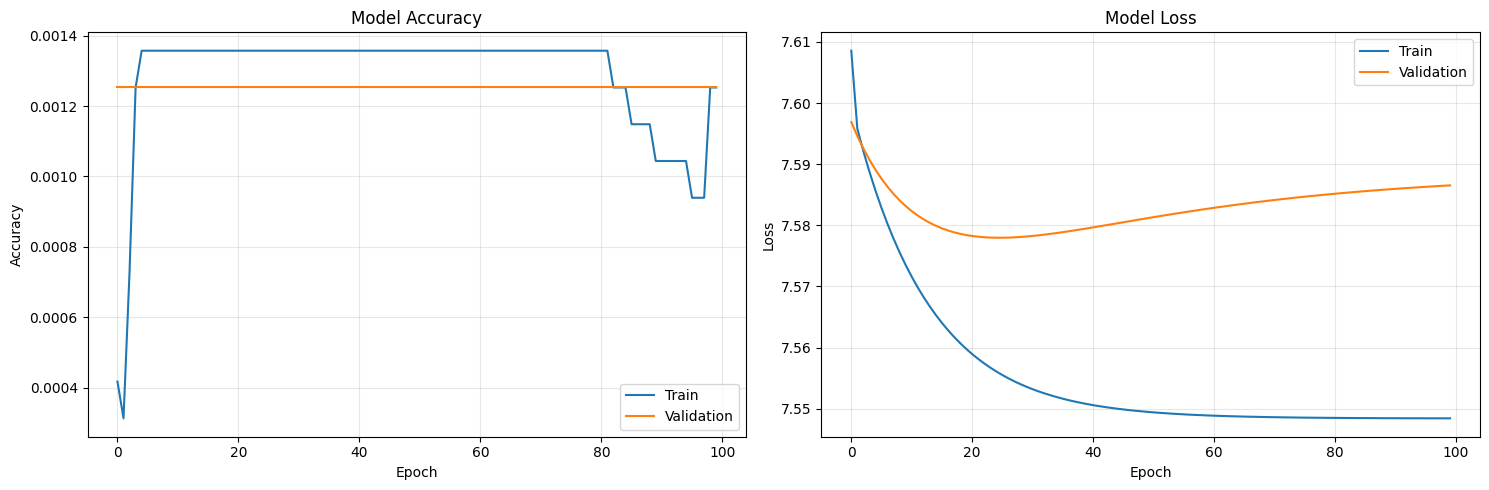

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Test accuracy: 0.0013

Example predictions:
True: wow, Predicted: cool
True: dawn, Predicted: cool
True: terrible, Predicted: cool
True: bird, Predicted: cool
True: sweep, Predicted: cool


In [70]:
# Plot training history
plot_training_history(history)

# Evaluate model
evaluate_model(model, X_test, y_test, sign_map)